<a href="https://colab.research.google.com/github/sunnysavita10/Complete-LLM-Finetuning/blob/main/Knowledge_DIstillation_in_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step by Step Samjha:
Dataset Load:

MNIST (0–9 digits), normalize kar ke batches banaye.

Teacher & Student Models:

Dono simple MLP networks.

Teacher ka hidden size zyada (512 neurons) → accurate par slow.

Student ka chhota (128 neurons) → fast par kam power.

Teacher Training:

Teacher ko normal supervised learning se train karte hain CrossEntropy loss ke sath.

Fir freeze (train nahi karte aage).

Distillation (Main Step):

Har batch pe:

Teacher ke logits ko temperature se softmax karke soft targets banate hain (probability distribution).

Student ka output lete hain aur KL Divergence (teacher vs student) loss nikalte hain.

Saath me normal label loss (CrossEntropy) bhi lete hain.

Final loss = alpha*soft + (1-alpha)*hard.

Result:

Student chhota hai par Teacher ki "knowledge" copy karke accuracy high rakhta hai.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

1. transforms.ToTensor()

MNIST images are originally in PIL Image format (28×28 grayscale).

This converts them into a PyTorch Tensor, and also scales pixel values to the [0,1] range.

Originally, pixel values are between 0–255.

After ToTensor(), each pixel becomes pixel / 255.

2. transforms.Normalize((0.5,), (0.5,))
This further shifts and scales pixel values to the [-1, 1] range.

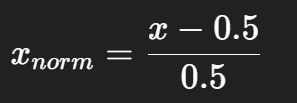
​

where x is the pixel value in [0,1] (after ToTensor()).

Meaning:

0 → -1

0.5 → 0

1 → +1

We normalize like this because:

Neural networks train better when inputs are centered around zero (mean ≈ 0).

It helps speed up training and prevents issues like exploding/vanishing gradients.

In [3]:
# ----- 1. Dataset (MNIST) -----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1000)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.64MB/s]


In [5]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

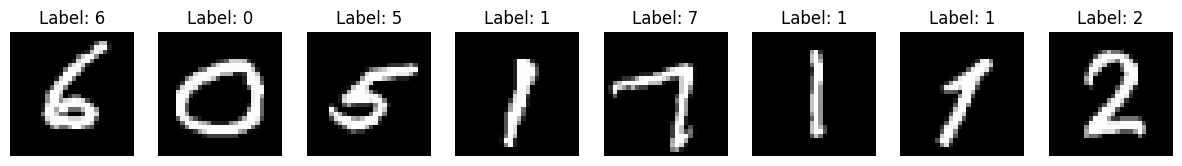

In [6]:
fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap='gray')  # grayscale
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.show()


In [7]:
import torch
import torch.nn as nn

# ----- Teacher Model (2 hidden layers) -----
class TeacherMLP(nn.Module):
    def __init__(self, hidden1=512, hidden2=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 10)  # 10 output classes (digits)
        )
    def forward(self, x):
        return self.net(x)


# ----- Student Model (1 hidden layer) -----
class StudentMLP(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 10)  # smaller model, only 1 hidden layer
        )
    def forward(self, x):
        return self.net(x)


# Create instances
teacher = TeacherMLP(hidden1=512, hidden2=256)
student = StudentMLP(hidden=128)

print(teacher)
print(student)

TeacherMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)
StudentMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [8]:
# ----- 3. Train Teacher -----
def train_teacher(model, loader, epochs=3, lr=1e-3):
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for x, y in loader:
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"Teacher Epoch {ep+1}: Loss = {total_loss/len(loader):.4f}")

In [9]:
train_teacher(teacher, train_loader)

Teacher Epoch 1: Loss = 0.3002
Teacher Epoch 2: Loss = 0.1386
Teacher Epoch 3: Loss = 0.1040


In [10]:
teacher.eval()

TeacherMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [11]:
# ----- 4. Distillation Training -----
temperature = 2.0
alpha = 0.7
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.Adam(student.parameters(), lr=1e-3)

In [12]:
def distill(student, teacher, loader, epochs=3):
    for ep in range(epochs):
        student.train()
        total_loss = 0
        for x, y in loader:
            # Teacher outputs
            with torch.no_grad():
                t_logits = teacher(x)
                t_probs = torch.softmax(t_logits / temperature, dim=1)

            # Student outputs
            s_logits = student(x)
            s_log_probs = torch.log_softmax(s_logits / temperature, dim=1)

            # Losses
            loss_soft = kl_loss(s_log_probs, t_probs) * (temperature**2)
            loss_hard = ce_loss(s_logits, y)
            loss = alpha * loss_soft + (1 - alpha) * loss_hard

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Student Epoch {ep+1}: Loss = {total_loss/len(loader):.4f}")

In [13]:
distill(student, teacher, train_loader)

Student Epoch 1: Loss = 0.8256
Student Epoch 2: Loss = 0.2762
Student Epoch 3: Loss = 0.1501


In [14]:
# ----- 5. Evaluation Function -----
def evaluate(model, loader, name="Model"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total * 100
    print(f"{name} Accuracy: {acc:.2f}%")
    return acc

In [15]:
# Evaluate both Teacher and Student
evaluate(teacher, test_loader, "Teacher")

Teacher Accuracy: 97.18%


97.18

In [16]:
evaluate(student, test_loader, "Student")

Student Accuracy: 96.27%


96.27

In [17]:
# ----- 6. Sample Predictions -----
def predict(model, x):
    model.eval()
    with torch.no_grad():
        out = model(x)
        return out.argmax(dim=1)

In [18]:
sample_batch, sample_labels = next(iter(test_loader))

In [19]:
preds = predict(student, sample_batch)

In [20]:
print("Sample predictions (Student):", preds[:20])

Sample predictions (Student): tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])


In [21]:
print("True labels:", sample_labels[:20])

True labels: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])


In [22]:
# ----- 7. Save Student Model -----
torch.save(student.state_dict(), "distilled_student.pth")
print("Student model saved as distilled_student.pth")

Student model saved as distilled_student.pth


### With Classical LM (Bert)


| Block                   | Purpose (Hindi explain)                                                                                                    |
| ----------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| **0. Imports & config** | Sab library, GPU detect, hyperparameters set.                                                                              |
| **1. Dataset**          | Demo dataset load + tokenization; collator pad karega.                                                                     |
| **2. Models**           | BERT teacher load (freeze), DistilBERT student load (trainable).                                                           |
| **3. Losses**           | CE (hard) + KL (soft); temperature se softmax blur.                                                                        |
| **4. Optimizer**        | AdamW + linear LR schedule.                                                                                                |
| **5. distill\_epoch()** | Har batch: <br>• Teacher logits → soft targets <br>• Student logits <br>• Loss combine (α) <br>• Backprop only on student. |
| **evaluate()**          | Validation accuracy check.                                                                                                 |
| **Loop**                | epochs ke liye train + eval.                                                                                               |
| **Save**                | Fine‑tuned student ko disk pe dump kar diya.                                                                               |


Tip: Badi dataset + multiple GPUs/TPUs pe chalane ke liye Trainer ka DistillationTrainer wrapper ya Accelerate use kar sakta hai—logic same hi rahega.

Yahan kya ho raha hai step by step:

Teacher Output (t_soft)

Teacher (bada model) ka output logits le rahe hain.

Temperature (T=2.0) use karke softmax ko smooth banaya — iska matlab teacher sirf “ye class 1 hai” nahi bolta, balki probability distribution deta (e.g., 0.6, 0.3, 0.1).

Student Output (s_soft)

Student model bhi wahi input pe logits deta hai.

Hum log-softmax nikalte hain taaki KL Divergence calculate ho sake.

Distillation Loss (loss_soft)

KLDivLoss calculate karta hai ki Student ka probability distribution Teacher ke soft distribution se kitna alag hai.

temperature**2 multiply karke scale adjust karte hain (Hinton paper ka rule).

Final Loss

loss = alpha_soft * loss_soft + (1 - alpha_soft) * loss_hard

Matlab Student dono sikh raha hai:

Teacher ki knowledge (soft targets).

Dataset ke true labels (hard targets).

Ye teacher-student training hi knowledge distillation hai. Agar sirf loss_hard use hota, to normal fine-tuning hoti, distillation nahi.

In [2]:
!pip install --upgrade datasets fsspec transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 69.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.7.0
    Uninstalling fsspec-2025.7.0:
      Successfully uninstalled fsspec-2025.7.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.2
    Uninstalling transformers-4.53.2:
      Successfully uninstalled transformers-4.53.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
t

In [19]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader

batch_size   = 16
lr           = 5e-5
epochs       = 3
temperature  = 2.0
alpha_soft   = 0.5
max_len      = 128
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load dataset
raw = load_dataset("tweet_eval", "sentiment")

# 2. Subset (2.5k samples for train)
train_small = raw['train'].shuffle(seed=42).select(range(2500))
val_small   = raw['validation']

# 3. Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, max_length=max_len)

# 4. Tokenize & remove original text column
tokenized = {}
tokenized['train'] = train_small.map(tokenize, batched=True, remove_columns=['text'])
tokenized['validation'] = val_small.map(tokenize, batched=True, remove_columns=['text'])

# 5. Data Collator (auto-padding)
collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

# 6. DataLoaders
train_dl = DataLoader(tokenized['train'], batch_size=batch_size,
                      shuffle=True, collate_fn=collator)

val_dl = DataLoader(tokenized['validation'], batch_size=batch_size,
                    shuffle=False, collate_fn=collator)


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [20]:
teacher = AutoModelForSequenceClassification.from_pretrained(
    "bert-large-uncased", num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
student = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Freeze teacher (no training)
for p in teacher.parameters():
    p.requires_grad = False
teacher.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [23]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.AdamW(student.parameters(), lr=lr)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dl) * epochs,
)

In [24]:
def distill_epoch():
    student.train()
    pbar = tqdm(train_dl, desc="Train")
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention = batch["attention_mask"].to(device)
        labels    = batch["labels"].to(device)

        # Teacher predictions (soft targets)
        with torch.no_grad():
            t_logits = teacher(input_ids, attention_mask=attention).logits
            t_soft   = torch.softmax(t_logits / temperature, dim=1)

        # Student predictions
        s_logits = student(input_ids, attention_mask=attention).logits
        s_soft   = torch.log_softmax(s_logits / temperature, dim=1)

        # Distillation + CE Loss
        loss_soft = kl_loss(s_soft, t_soft) * (temperature ** 2)
        loss_hard = ce_loss(s_logits, labels)
        loss      = alpha_soft * loss_soft + (1 - alpha_soft) * loss_hard

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

In [25]:
def evaluate():
    student.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in val_dl:
            ids  = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            lbl  = batch["labels"].to(device)
            out  = student(ids, attention_mask=attn).logits
            pred = out.argmax(dim=1)
            correct += (pred == lbl).sum().item()
            total   += lbl.size(0)
    return round(correct / total * 100, 2)


In [26]:
for ep in range(1, epochs + 1):
    distill_epoch()
    acc = evaluate()
    print(f"Epoch {ep}/{epochs} | Validation Accuracy: {acc}%")

Train: 100%|██████████| 157/157 [00:49<00:00,  3.14it/s, loss=0.3895]


Epoch 1/3 | Validation Accuracy: 66.0%


Train: 100%|██████████| 157/157 [00:51<00:00,  3.07it/s, loss=0.4004]


Epoch 2/3 | Validation Accuracy: 69.6%


Train: 100%|██████████| 157/157 [00:49<00:00,  3.18it/s, loss=0.4056]


Epoch 3/3 | Validation Accuracy: 69.8%


In [27]:
# ---------- 6. Save Student ----------
student.save_pretrained("distilled_student_model")
tokenizer.save_pretrained("distilled_student_model")
print(" Done!  Student model saved to ./distilled_student_model")

 Done!  Student model saved to ./distilled_student_model


## With LLM


Yeh kya karta hai?

Teacher (LLaMA‑2 7B) har prompt pe apna distribution (probabilities for next word) deta hai.

Student (TinyLLaMA 1.1B) ko train karte hain ki wo:

Teacher ke distribution ko mimic kare (KLDivLoss → soft targets).

Saath hi apne labels (next token) pe bhi correct ho (CrossEntropyLoss → hard targets).

Har prompt pe backpropagation sirf Student ke weights par hota hai.

Result me Student Teacher ke reasoning ko copy karta hai, but size aur speed me chhota ho jata hai.

Reality me kaise chalate hain?

Ye bas mini example hai (3 prompts).

Actual distillation me:

Millions of prompts (synthetic bhi) use hote hain.

Batch training + Accelerate/Deepspeed use hota hai (GPU memory manage karne ke liye).

Teacher output ko offline save karke Student ko train karte hain (fast pipeline).

In [28]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

In [19]:
# ----- Models -----
teacher_id = "meta-llama/Llama-2-7b-chat-hf"      # big model (teacher)

In [20]:
student_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"  # small model (student)

In [21]:
teacher = AutoModelForCausalLM.from_pretrained(teacher_id, torch_dtype=torch.float16, device_map="auto")

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [22]:
student = AutoModelForCausalLM.from_pretrained(student_id, torch_dtype=torch.float16, device_map="auto")

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [23]:
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [28]:
# for p in teacher.parameters():
#     print(p)

In [29]:
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

In [ ]:
# prompts = [
#     "Explain why the sky is blue.",
#     "What is the capital of France?",
#     "Write a short story about a robot and a cat."
# ]

In [35]:
prompts = [
    "Explain why the sky is blue. ### The sky appears blue because molecules in Earth's atmosphere scatter sunlight, and blue light is scattered more than other colors due to its shorter wavelength.",
    "What is the capital of France? ### The capital of France is Paris.",
    "Write a short story about a robot and a cat. ### Once upon a time, a lonely robot found a stray cat. They became best friends, exploring the city together, and the robot learned the meaning of companionship."
]


In [36]:
# ----- Distillation Hyperparams -----
temperature = 2.0
alpha_soft  = 0.7
ce_loss     = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
kl_loss     = nn.KLDivLoss(reduction="batchmean")
optimizer   = optim.AdamW(student.parameters(), lr=2e-5)

In [37]:
tokenizer = AutoTokenizer.from_pretrained(teacher_id)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # padding fix
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

In [38]:
# Recreate CrossEntropyLoss with correct ignore_index
ce_loss = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

In [39]:
for prompt in prompts:
    # Tokenize with pad token now set
    enc = tokenizer(prompt, return_tensors="pt", padding=True).to(student.device)

    # Teacher output (no grad)
    with torch.no_grad():
        t_logits = teacher(**enc).logits[:, :-1, :]
        t_soft = torch.softmax(t_logits / temperature, dim=-1)

    # Student output
    s_logits = student(**enc).logits[:, :-1, :]
    s_log_soft = torch.log_softmax(s_logits / temperature, dim=-1)

    # Shift labels for next-token prediction
    labels = enc["input_ids"][:, 1:].contiguous()

    # Hard loss (CrossEntropy)
    loss_hard = ce_loss(s_logits.view(-1, s_logits.size(-1)), labels.view(-1))

    # Soft loss (KL Divergence)
    loss_soft = kl_loss(s_log_soft, t_soft) * (temperature ** 2)

    # Final combined loss
    loss = alpha_soft * loss_soft + (1 - alpha_soft) * loss_hard

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Prompt: {prompt[:30]}..., Loss: {loss.item():.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 20.12 MiB is free. Process 11420 has 14.72 GiB memory in use. Of the allocated memory 14.53 GiB is allocated by PyTorch, and 62.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)